# 1. Setup

In [1]:
import os
import time
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.models import resnet18
from sklearn.metrics import accuracy_score, confusion_matrix

from PIL import Image

In [2]:
train_dir = 'Data/Train'
val_dir = 'Data/Val'
test_dir = 'Data/Test'

In [3]:
num_cpus = os.cpu_count()

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# 2. Define dataset

In [5]:
transform_ops = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [6]:
inverse_transform_ops = transforms.Compose([
                            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
                        ])

In [7]:
trainset = datasets.ImageFolder(root=train_dir, transform=transform_ops)
valset = datasets.ImageFolder(root=val_dir, transform=transform_ops)
testset = datasets.ImageFolder(root=test_dir, transform=transform_ops)
print(len(trainset), len(valset), len(testset))

30000 1200 1200


In [8]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=num_cpus)
print(len(train_loader), len(val_loader), len(test_loader))

1875 75 75


# 3. Define ultilties

In [9]:
print(trainset.class_to_idx)
print(valset.class_to_idx)
print(testset.class_to_idx)

{'English': 0, 'Hindi': 1, 'Malayalam': 2, 'Punjabi': 3, 'Tamil': 4, 'Telugu': 5}
{'English': 0, 'Hindi': 1, 'Malayalam': 2, 'Punjabi': 3, 'Tamil': 4, 'Telugu': 5}
{'English': 0, 'Hindi': 1, 'Malayalam': 2, 'Punjabi': 3, 'Tamil': 4, 'Telugu': 5}


In [10]:
class2idx = trainset.class_to_idx
idx2class = {v:k for k, v in class2idx.items()}
print(class2idx)
print(idx2class)

{'English': 0, 'Hindi': 1, 'Malayalam': 2, 'Punjabi': 3, 'Tamil': 4, 'Telugu': 5}
{0: 'English', 1: 'Hindi', 2: 'Malayalam', 3: 'Punjabi', 4: 'Tamil', 5: 'Telugu'}


In [11]:
def plot_image(image_tensor, title=""):
    """
    Arguments:
    image_tensor -- tensor of Size([1, n_h, n_w,]) / Size([3, n_h+4, n_w*m+4])
    """
    image_tensor = inverse_transform_ops(image_tensor)
    image_array = image_tensor.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(20, 20))
    plt.imshow(image_array)
    plt.title(title)
    return plt.show()

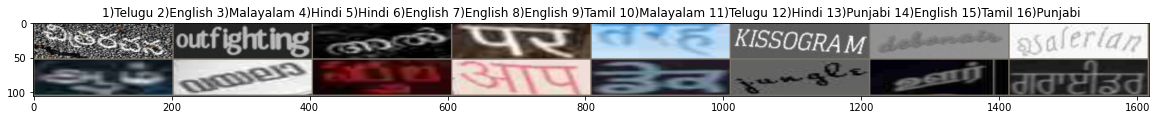

In [12]:
X, Y = iter(train_loader).next()
m = 16
image_grid = utils.make_grid(X[:m])
names = " ".join([f'{i}){idx2class[y.item()]}' for i, y in enumerate(Y[:m], start=1)])
plot_image(image_grid, title=names)

# 4. Define model

In [13]:
resnet = resnet18(pretrained=True)
for p in resnet.parameters():
    pass#p.requires_grad = False

In [14]:
class Model1(nn.Module):
    
    def __init__(self):
        
        super(Model, self).__init__()
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.2)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn = nn.Sequential(*resnet_modules)
        self.linear1 = nn.Linear(1024, 64)
        self.linear2 = nn.Linear(13*64, 32)
        self.out = nn.Linear(32, 6)
        
        
    def forward(self, batch):
        
        batch = self.cnn(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp1(batch)
        # print(batch.size()) # torch.Size([-1, 13, 64])
        batch = batch.view(batch_size, -1) 
        # print(batch.size()) # torch.Size([-1, 13*64])
            
        batch = self.linear2(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 16])
        
        batch = self.out(batch) # [batch_size, num_classes]
        # print(batch.size()) # torch.Size([-1, 2])
        
        return batch

In [15]:
class Model2(nn.Module):
    
    def __init__(self, rnn_hidden_size=256):
        
        super(Model2, self).__init__()
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.4)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, 16)
        self.out = nn.Linear(13*16, 6)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 16])
        
        # batch = batch[:, -1, :] 
        # print(batch.size()) # torch.Size([-1, 16])
        batch = batch.view(batch_size, -1) 
        # print(batch.size()) # torch.Size([-1, 13*16])
        
        batch = self.out(batch)
        # print(batch.size()) # torch.Size([-1, 5])
        
        return batch

# 5. Train model

In [16]:
train_batch_size = 64

lr = 0.0001
weight_decay = 0.01
step_size = 5
gamma = 0.9

num_epochs = 30
print_every = num_epochs // 10

In [17]:
model = Model2()
model = model.to(device)

In [18]:
weight = torch.Tensor([1., 1., 1., 1., 1., 1.]).to(device)
criterion = nn.CrossEntropyLoss(reduction="mean", weight=weight)
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

In [19]:
epoch_losses = []
epoch_losses_val = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss = 0
    epoch_loss_val = 0
    epoch_lr = 0
    
    model.train()
    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch), leave=False):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_last_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_last_lr()[0]
        
    model.eval()
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        epoch_loss_val += loss.item()
        
    lr_scheduler.step()
    epoch_loss /= len(train_loader)
    epoch_loss_val /= len(val_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every == 0:    
        message = "Epoch:{}    TrainLoss:{}    ValLoss:{}    LR:{}".format(epoch, 
                                                                           epoch_loss, 
                                                                           epoch_loss_val, 
                                                                           epoch_lr)
        model_path = f'Models/Language-Classifier-e{epoch}.pth'
        torch.save(model.state_dict(), model_path)
        print(message)

Epoch:3    TrainLoss:0.24101245564222334    ValLoss:0.2716616240143776    LR:9.999999999999769e-05


Epoch:6    TrainLoss:0.15067721088727315    ValLoss:0.20497511585553488    LR:9.000000000000417e-05


Epoch:9    TrainLoss:0.1184747509876887    ValLoss:0.18067092587550482    LR:9.000000000000417e-05


Epoch:12    TrainLoss:0.09148413872718811    ValLoss:0.15665888537963232    LR:8.099999999999832e-05


Epoch:15    TrainLoss:0.07939408306280772    ValLoss:0.21942980835835138    LR:8.099999999999832e-05


Epoch:18    TrainLoss:0.06257236260175705    ValLoss:0.16304800073305767    LR:7.289999999999951e-05


Epoch:21    TrainLoss:0.046028821154435476    ValLoss:0.23185890595118205    LR:6.56099999999972e-05


Epoch:24    TrainLoss:0.05413088699181875    ValLoss:0.17305371671915054    LR:6.56099999999972e-05


Epoch:27    TrainLoss:0.043265950965881345    ValLoss:0.17178233921527863    LR:5.904900000000177e-05


Epoch:30    TrainLoss:0.038329480655988055    ValLoss:0.1645814240972201    LR:5.904900000000177e-05



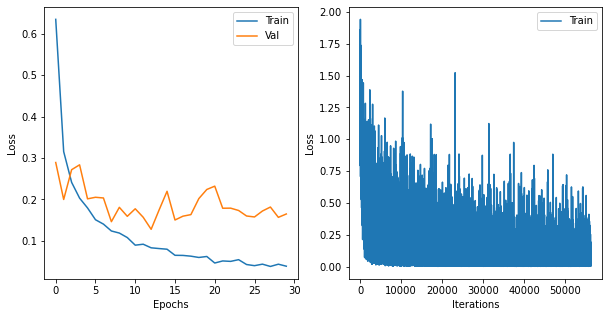

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses, label='Train')
ax1.plot(epoch_losses_val, label='Val')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(iteration_losses, label='Train')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

In [21]:
model_path = f'Models/Language-Classifier.pth'
torch.save(model.state_dict(), model_path)

# 6. Check Performance

In [31]:
model_path = f'Models/Language-Classifier-e12.pth' # Final Model
model = Model2()
model.load_state_dict(torch.load(model_path))
model.to(device)
model = model.eval()

In [32]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['actual', 'prediction'])
    for X, Y in tqdm(data_loader, leave=False):
        X, Y = X.to(device), Y.to(device)
        Y_pred_logits = model(X)
        Y_pred = torch.argmax(Y_pred_logits, dim=1)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = Y.cpu().detach().numpy()
        df['prediction'] = Y_pred.cpu().detach().numpy()
        result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    result['actual'] = result['actual'].map(idx2class)
    result['prediction'] = result['prediction'].map(idx2class)
    result['file_path'] = [sample[0] for sample in data_loader.dataset.samples]
    return result

In [33]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=False, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=num_cpus)

train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [34]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(30000, 3)
(1200, 3)
(1200, 3)


,actual,prediction,file_path
0,English,English,Data/Train/English/002101_18_2.jpg
1,English,Telugu,Data/Train/English/165_238_31.jpg
2,English,English,Data/Train/English/22_79_62.jpg
3,English,English,Data/Train/English/2th_434_77.jpg
4,English,English,Data/Train/English/4TH_249_101.jpg


In [35]:
train_result.describe()

,actual,prediction,file_path
count,30000,30000,30000
unique,6,6,30000
top,Punjabi,Tamil,Data/Train/Hindi/कर_7_3774_1.jpg
freq,5000,5166,1


In [36]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction'])
print(train_accuracy, val_accuracy, test_accuracy)

0.9865666666666667 0.9433333333333334 0.9566666666666667


In [37]:
cm = confusion_matrix(test_result['actual'], test_result['prediction'])
cm = pd.DataFrame(cm, index=idx2class.values(), columns=idx2class.values())
cm

,English,Hindi,Malayalam,Punjabi,Tamil,Telugu
English,194,0,3,0,1,2
Hindi,0,195,0,4,1,0
Malayalam,0,0,179,1,19,1
Punjabi,0,6,0,192,1,1
Tamil,0,1,3,1,195,0
Telugu,0,1,0,2,4,193


In [38]:
def visualize_misclassifications(result, num_samples=20):
    
    result = result[result.actual != result.prediction]
    result = result.sample(n = num_samples)
    for row_id, row in result.iterrows():
        image_fp = row['file_path']
        info = f'Actual: {row.actual};    Prediction: {row.prediction}'
        print(info)
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show() 

Actual: Punjabi;    Prediction: Hindi


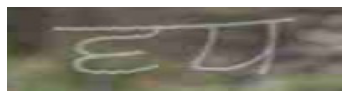

Actual: Malayalam;    Prediction: Tamil


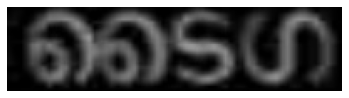

Actual: Hindi;    Prediction: Punjabi


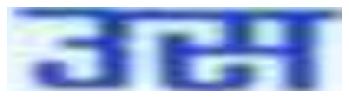

Actual: Malayalam;    Prediction: Tamil


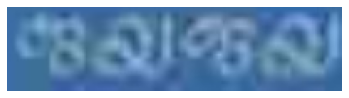

Actual: Malayalam;    Prediction: Tamil


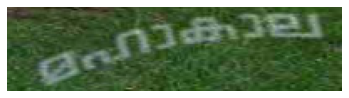

Actual: Tamil;    Prediction: Malayalam


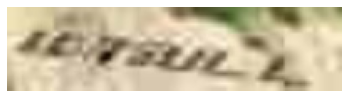

Actual: Hindi;    Prediction: Tamil


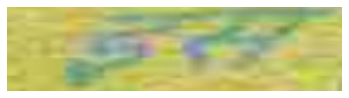

Actual: Malayalam;    Prediction: Telugu


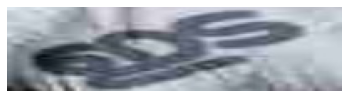

Actual: Hindi;    Prediction: Punjabi


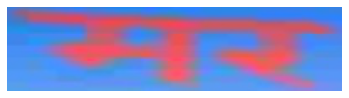

Actual: Malayalam;    Prediction: Tamil


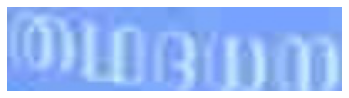

Actual: English;    Prediction: Telugu


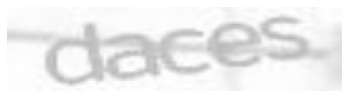

Actual: English;    Prediction: Tamil


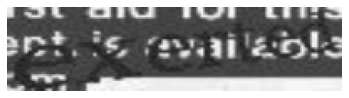

Actual: Punjabi;    Prediction: Tamil


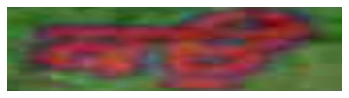

Actual: Telugu;    Prediction: Hindi


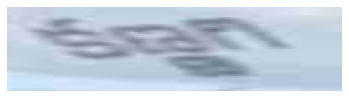

Actual: Telugu;    Prediction: Punjabi


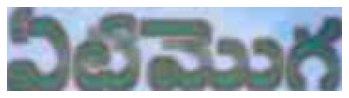

Actual: Malayalam;    Prediction: Tamil


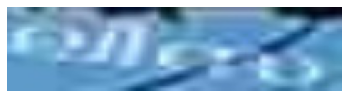

Actual: Malayalam;    Prediction: Punjabi


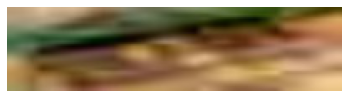

Actual: Malayalam;    Prediction: Tamil


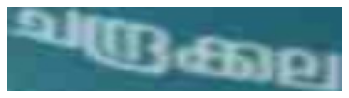

Actual: Malayalam;    Prediction: Tamil


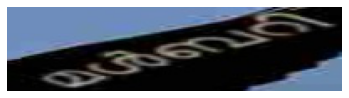

Actual: Hindi;    Prediction: Punjabi


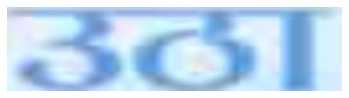

In [39]:
visualize_misclassifications(test_result, num_samples=20)

**References:**
1. https://github.com/GokulKarthik/Deep-Learning-Projects.pytorch